In [1]:
import util
import vqe_class
import ansatz_circ

import numpy as np
import math
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mpl
from matplotlib import animation

from qiskit.primitives import Estimator,Sampler
from qiskit_aer import AerSimulator
from qiskit.algorithms.optimizers import COBYLA,NFT,GradientDescent,ADAM

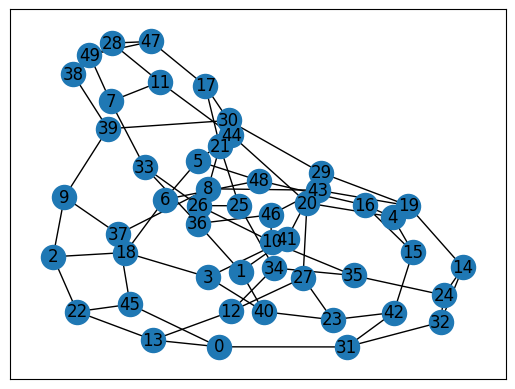

In [2]:
n_vertex=50
graph=nx.random_regular_graph(3,n_vertex)
#p=0.6
#graph=nx.gnp_random_graph(n_vertex,p)
#graph=nx.barabasi_albert_graph(n_vertex,4)
#graph=util.generate_random_graph(n_vertex,0.5)
sum=0
# Assign random weights to edges
for edge in graph.edges():
    #a=np.random.rand(1)[0]
    a=1
    sum+=a
    #graph.edges[edge]['weight'] = np.random.rand()
    graph.edges[edge]['weight'] = 1
nx.draw_networkx(graph)

In [3]:
#max=np.max(list(util.Hamiltonian_spectrum(graph).values()))
max=util.gw_cut(graph)

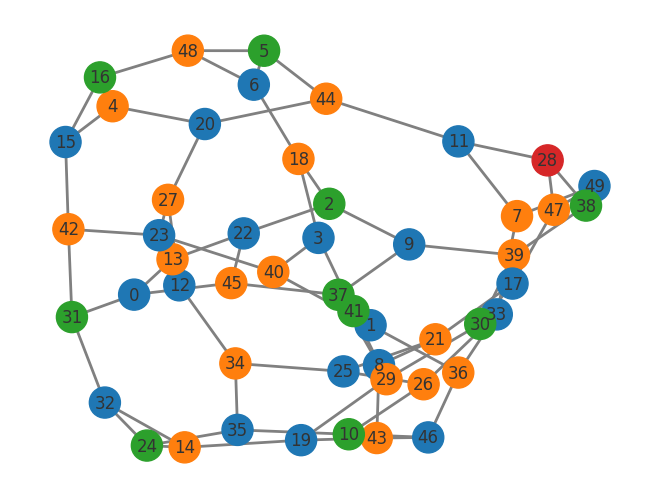

In [4]:
graph_coloring = nx.greedy_color(graph)

unique_colors = set(graph_coloring.values())

# Assign colors to nodes based on the greedy coloring
graph_color_to_mpl_color = dict(zip(unique_colors, mpl.TABLEAU_COLORS))
node_colors = [graph_color_to_mpl_color[graph_coloring[n]] for n in graph.nodes()]

pos = nx.spring_layout(graph, seed=14)
nx.draw(
    graph,
    pos,
    with_labels=True,
    node_size=500,
    node_color=node_colors,
    edge_color="grey",
    font_size=12,
    font_color="#333333",
    width=2,
)

In [5]:
nft=NFT(maxiter=1000, maxfev=1024, disp=False, reset_interval=1000, options=None)
cobyla=COBYLA(maxiter=1000, disp=True, rhobeg=0.01, tol=0.01, options=None)
adam=ADAM(maxiter=300, tol=1e-02, lr=0.5, beta_1=0.98, beta_2=0.99, noise_factor=1e-08, eps=1e-2, amsgrad=True, snapshot_dir=None)
g_d=GradientDescent(maxiter=300,learning_rate=0.01, tol=0.01, callback=None, perturbation=None)



estimator_dens= AerSimulator(method='density_matrix')
estimator_state= AerSimulator(method='statevector')
estimator = Estimator()
sampler = Sampler()


In [6]:
n_vertex=len(graph.nodes())
num_qubits=len(util.operator_vertex(graph)[0][0])
alpha=np.sqrt(len(graph.nodes()))

ans_ent=ansatz_circ.ansatz_efficient(num_qubits,int(num_qubits/2)+1)
ans=ansatz_circ.sep_ansatz(graph,3)
circuits=ansatz_circ.multibasis_ansatz(ans)
circuits_ent=ansatz_circ.multibasis_ansatz(ans_ent)

20
4
19
4
10
3
9


In [7]:
stat=4
res_quad_sep_warm=[]
res_quad_ent_warm=[]
res_nonlin_sep_warm=[]
res_nonlin_ent_warm=[]
for i in range (stat):


    gw_cut=util.gw_cut(graph)
    beta=1
    v=gw_cut
    gamma=0
    cobyla=COBYLA(maxiter=1000, disp=True, rhobeg=1, tol=0.01, options=None)
    intermediate_info_init= []
    def callback(data):
        intermediate_info_init.append(data)
    qrao=vqe_class.QRAO_initial_state_VQE(graph,sampler,circuits,cobyla,gw_cut,alpha,beta,v,gamma,shots=None,initial_parameters=None,callback=callback)
    result_init=qrao.compute_minimum_eigenvalue(min)
    new_init_sep=result_init.optimal_parameters


    qrao=vqe_class.QRAO_initial_state_VQE(graph,sampler,circuits_ent,cobyla,gw_cut,alpha,beta,v,gamma,shots=None,initial_parameters=None,callback=callback)
    result_init_ent=qrao.compute_minimum_eigenvalue(min)
    new_init_ent=result_init_ent.optimal_parameters


    v=0
    gamma=0
    cobyla=COBYLA(maxiter=3000, disp=True, rhobeg=0.1, tol=0.01, options=None)
    intermediate_info_qrao= []
    def callback(data):
        intermediate_info_qrao.append(data)
    qrao=vqe_class.QRAO_quadratic_VQE(graph,sampler,circuits,cobyla,gw_cut,alpha,beta,v,gamma,shots=None,initial_parameters=new_init_sep,callback=callback)
    result_qrao= qrao.compute_minimum_eigenvalue(min)
    new_init=result_qrao.optimal_parameters
    v=gw_cut/2
    gamma=1
    cobyla=COBYLA(maxiter=3000, disp=True, rhobeg=0.1, tol=0.01, options=None)
    #intermediate_info_qrao= []
    def callback(data):
        intermediate_info_qrao.append(data)
    qrao=vqe_class.QRAO_quadratic_VQE(graph,sampler,circuits,cobyla,gw_cut,alpha,beta,v,gamma,shots=None,initial_parameters=new_init,callback=callback)
    result_qrao= qrao.compute_minimum_eigenvalue(min)
    res_quad_sep_warm.append(result_qrao.eigenvalue/max)
    


    v=gw_cut
    gamma=0
    cobyla=COBYLA(maxiter=3000, disp=True, rhobeg=0.05, tol=0.01, options=None)
    intermediate_info_qrao_non_linear= []
    def callback(data):
        intermediate_info_qrao_non_linear.append(data)
    qrao=vqe_class.QRAO_nonlinear_VQE(graph,sampler,circuits,cobyla,gw_cut,alpha,beta,v,gamma,shots=None,initial_parameters=new_init_sep,callback=callback)
    result_qrao_non= qrao.compute_minimum_eigenvalue(min)
    new_init=result_qrao_non.optimal_parameters


    v=gw_cut/2
    gamma=1

    cobyla=COBYLA(maxiter=3000, disp=True, rhobeg=0.05, tol=0.01, options=None)
    #intermediate_info_qrao_non_linear= []
    def callback(data):
        intermediate_info_qrao_non_linear.append(data)
    qrao=vqe_class.QRAO_nonlinear_VQE(graph,sampler,circuits,cobyla,gw_cut,alpha,beta,v,gamma,shots=None,initial_parameters=new_init,callback=callback)
    result_qrao_non= qrao.compute_minimum_eigenvalue(min)
    res_nonlin_sep_warm.append(result_qrao_non.eigenvalue/max)







    v=0
    gamma=0
    cobyla=COBYLA(maxiter=3000, disp=True, rhobeg=0.1, tol=0.01, options=None)
    intermediate_info_qrao= []
    def callback(data):
        intermediate_info_qrao.append(data)
    qrao=vqe_class.QRAO_quadratic_VQE(graph,sampler,circuits_ent,cobyla,gw_cut,alpha,beta,v,gamma,shots=None,initial_parameters=new_init_ent,callback=callback)
    result_qrao= qrao.compute_minimum_eigenvalue(min)
    new_init=result_qrao.optimal_parameters
    v=gw_cut/2
    gamma=1
    cobyla=COBYLA(maxiter=3000, disp=True, rhobeg=0.1, tol=0.01, options=None)
    #intermediate_info_qrao= []
    def callback(data):
        intermediate_info_qrao.append(data)
    qrao=vqe_class.QRAO_quadratic_VQE(graph,sampler,circuits_ent,cobyla,gw_cut,alpha,beta,v,gamma,shots=None,initial_parameters=new_init,callback=callback)
    result_qrao= qrao.compute_minimum_eigenvalue(min)
    res_quad_ent_warm.append(result_qrao.eigenvalue/max)
    


    v=gw_cut
    gamma=0
    cobyla=COBYLA(maxiter=3000, disp=True, rhobeg=0.05, tol=0.01, options=None)
    intermediate_info_qrao_non_linear= []
    def callback(data):
        intermediate_info_qrao_non_linear.append(data)
    qrao=vqe_class.QRAO_nonlinear_VQE(graph,sampler,circuits_ent,cobyla,gw_cut,alpha,beta,v,gamma,shots=None,initial_parameters=new_init_ent,callback=callback)
    result_qrao_non= qrao.compute_minimum_eigenvalue(min)
    new_init=result_qrao_non.optimal_parameters


    v=gw_cut/2
    gamma=1

    cobyla=COBYLA(maxiter=3000, disp=True, rhobeg=0.05, tol=0.01, options=None)
    #intermediate_info_qrao_non_linear= []
    def callback(data):
        intermediate_info_qrao_non_linear.append(data)
    qrao=vqe_class.QRAO_nonlinear_VQE(graph,sampler,circuits_ent,cobyla,gw_cut,alpha,beta,v,gamma,shots=None,initial_parameters=new_init,callback=callback)
    result_qrao_non= qrao.compute_minimum_eigenvalue(min)
    res_nonlin_ent_warm.append(result_qrao_non.eigenvalue/max)

20
4
19
4
10
3


KeyboardInterrupt: 

In [ ]:
res_gw=[]
for i in range (stat):


    gw_cut=util.gw_cut(graph)
    res_gw.append(gw_cut/max)

NameError: name 'stat' is not defined

In [ ]:
res_quad_sep=[]
res_quad_ent=[]
res_nonlin_sep=[]
res_nonlin_ent=[]
for i in range (stat):
    v=0
    gamma=0
    cobyla=COBYLA(maxiter=3000, disp=True, rhobeg=0.1, tol=0.01, options=None)
    intermediate_info_qrao= []
    def callback(data):
        intermediate_info_qrao.append(data)
    qrao=vqe_class.QRAO_quadratic_VQE(graph,sampler,circuits,cobyla,gw_cut,alpha,beta,v,gamma,shots=None,initial_parameters=None,callback=callback)
    result_qrao= qrao.compute_minimum_eigenvalue(min)
    new_init=result_qrao.optimal_parameters
    v=gw_cut/2
    gamma=1
    cobyla=COBYLA(maxiter=3000, disp=True, rhobeg=0.1, tol=0.01, options=None)
    #intermediate_info_qrao= []
    def callback(data):
        intermediate_info_qrao.append(data)
    qrao=vqe_class.QRAO_quadratic_VQE(graph,sampler,circuits,cobyla,gw_cut,alpha,beta,v,gamma,shots=None,initial_parameters=new_init,callback=callback)
    result_qrao= qrao.compute_minimum_eigenvalue(min)
    res_quad_sep.append(result_qrao.eigenvalue/max)
    


    v=gw_cut
    gamma=0
    cobyla=COBYLA(maxiter=3000, disp=True, rhobeg=0.05, tol=0.01, options=None)
    intermediate_info_qrao_non_linear= []
    def callback(data):
        intermediate_info_qrao_non_linear.append(data)
    qrao=vqe_class.QRAO_nonlinear_VQE(graph,sampler,circuits,cobyla,gw_cut,alpha,beta,v,gamma,shots=None,initial_parameters=None,callback=callback)
    result_qrao_non= qrao.compute_minimum_eigenvalue(min)
    new_init=result_qrao_non.optimal_parameters


    v=gw_cut/2
    gamma=1

    cobyla=COBYLA(maxiter=3000, disp=True, rhobeg=0.05, tol=0.01, options=None)
    #intermediate_info_qrao_non_linear= []
    def callback(data):
        intermediate_info_qrao_non_linear.append(data)
    qrao=vqe_class.QRAO_nonlinear_VQE(graph,sampler,circuits,cobyla,gw_cut,alpha,beta,v,gamma,shots=None,initial_parameters=new_init,callback=callback)
    result_qrao_non= qrao.compute_minimum_eigenvalue(min)
    res_nonlin_sep.append(result_qrao_non.eigenvalue/max)







    v=0
    gamma=0
    cobyla=COBYLA(maxiter=3000, disp=True, rhobeg=0.1, tol=0.01, options=None)
    intermediate_info_qrao= []
    def callback(data):
        intermediate_info_qrao.append(data)
    qrao=vqe_class.QRAO_quadratic_VQE(graph,sampler,circuits_ent,cobyla,gw_cut,alpha,beta,v,gamma,shots=None,initial_parameters=None,callback=callback)
    result_qrao= qrao.compute_minimum_eigenvalue(min)
    new_init=result_qrao.optimal_parameters
    v=gw_cut/2
    gamma=1
    cobyla=COBYLA(maxiter=3000, disp=True, rhobeg=0.1, tol=0.01, options=None)
    #intermediate_info_qrao= []
    def callback(data):
        intermediate_info_qrao.append(data)
    qrao=vqe_class.QRAO_quadratic_VQE(graph,sampler,circuits_ent,cobyla,gw_cut,alpha,beta,v,gamma,shots=None,initial_parameters=new_init,callback=callback)
    result_qrao= qrao.compute_minimum_eigenvalue(min)
    res_quad_ent.append(result_qrao.eigenvalue/max)
    


    v=gw_cut
    gamma=0
    cobyla=COBYLA(maxiter=3000, disp=True, rhobeg=0.05, tol=0.01, options=None)
    intermediate_info_qrao_non_linear= []
    def callback(data):
        intermediate_info_qrao_non_linear.append(data)
    qrao=vqe_class.QRAO_nonlinear_VQE(graph,sampler,circuits_ent,cobyla,gw_cut,alpha,beta,v,gamma,shots=None,initial_parameters=None,callback=callback)
    result_qrao_non= qrao.compute_minimum_eigenvalue(min)
    new_init=result_qrao_non.optimal_parameters


    v=gw_cut/2
    gamma=1

    cobyla=COBYLA(maxiter=3000, disp=True, rhobeg=0.05, tol=0.01, options=None)
    #intermediate_info_qrao_non_linear= []
    def callback(data):
        intermediate_info_qrao_non_linear.append(data)
    qrao=vqe_class.QRAO_nonlinear_VQE(graph,sampler,circuits_ent,cobyla,gw_cut,alpha,beta,v,gamma,shots=None,initial_parameters=new_init,callback=callback)
    result_qrao_non= qrao.compute_minimum_eigenvalue(min)
    res_nonlin_ent.append(result_qrao_non.eigenvalue/max)

approxs
0.5264095975509311
-0.4310132008297062
0.3157894736842105
approxs
0.5268943075782501
-0.4322040106818365
0.3157894736842105
approxs
0.5251715085138371
-0.42985025168699703
0.3157894736842105
approxs
0.5267217457633929
-0.4316755355735921
0.3157894736842105
approxs
0.5251935808781995
-0.43140111743478365
0.3157894736842105
approxs
0.5263712225979278
-0.4347473202780432
0.3157894736842105
approxs
0.5247949232231734
-0.4299439094304209
0.3157894736842105
approxs
0.5274056884185929
-0.432157911935702
0.3157894736842105
approxs
0.5248495798543744
-0.4301652250776849
0.3157894736842105
approxs
0.5253390192453635
-0.4316590238920939
0.3157894736842105
approxs
0.5272504548862066
-0.4306880374135979
0.3157894736842105
approxs
0.527808527100951
-0.4323023262915229
0.3157894736842105
approxs
0.5277575394973064
-0.4313381373014452
0.3157894736842105
approxs
0.5319631730533876
-0.46770467745394895
0.3157894736842105
approxs
0.5258197230715036
-0.43723350667928
0.3157894736842105
approxs
0.5

In [ ]:
print(np.mean(np.array(res_quad_sep_warm)))
print(np.std(np.array(res_quad_sep_warm)))

print(np.mean(np.array(res_quad_ent_warm)))
print(np.std(np.array(res_quad_ent_warm)))

0.9605263157894737
0.02279014220485367
0.9210526315789472
0.0455802844097073


In [ ]:
print(np.mean(np.array(res_quad_sep)))
print(np.std(np.array(res_quad_sep)))

print(np.mean(np.array(res_quad_ent)))
print(np.std(np.array(res_quad_ent)))

0.9868421052631579
0.02279014220485367
0.9078947368421052
0.06837042661456096


In [ ]:
print(np.mean(np.array(res_nonlin_sep_warm)))
print(np.std(np.array(res_nonlin_sep_warm)))

print(np.mean(np.array(res_nonlin_ent_warm)))
print(np.std(np.array(res_nonlin_ent_warm)))

1.0
0.0
0.9605263157894737
0.06837042661456097


In [ ]:
print(np.mean(np.array(res_nonlin_sep)))
print(np.std(np.array(res_nonlin_sep)))

print(np.mean(np.array(res_nonlin_ent)))
print(np.std(np.array(res_nonlin_ent)))

1.0
0.0
1.0
0.0


In [ ]:
print(np.mean(np.array(res_gw)))
print(np.std(np.array(res_gw)))

1.0
0.0
